In [1]:
import itertools
from fractions import Fraction
from typing import Tuple, Sequence
from pprint import pprint

import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import theano as th
import theano.tensor as T
import pymc3 as pm

from hypothesis import given
from hypothesis import strategies as gen

In [2]:
from mockdown.learning.math.sequences import ext_farey

In [3]:
# %matplotlib widget
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")

## Constants

In [4]:
# Maximum y-noise in pixels.
ε_px = 3

# "Resolution": Maximum denominator for inferred slopes. 
# Also defines the range of allowed rationals (0 - R_MAX)
R_MAX = 30

B_MIN = -100
B_MAX = +100

A_MIN = 0
A_MAX = R_MAX

In [5]:
f_r = ext_farey(R_MAX)

TypeError: 'functools._lru_cache_wrapper' object is not subscriptable

In [241]:
TINY = 1e-20 # just a very small number

## Definitions

In [242]:
def q2cf(n1: int, n2: int):
    """Yields the continued fraction expansion of the rationals n1/n2."""
    while n2:
        n1, (term, n2) = n2, divmod(n1, n2)
        yield term

def sb_depth(n1: int, n2: int):
    """Returns the Stern-Brocot depth of the rationals n1/n2."""
    return sum(list(q2cf(n1, n2)))

def sweep(param_ranges, factor=None):
    """
    Returns a dataframe containing model.logp at every combination of possible parameters.
    """
    assert factor
    
    logp_fn = factor.logp
    rows = []
    
    keys, ranges = zip(*(param_ranges.items()))
    
    for values in itertools.product(*ranges):
        params = zip(keys, values)
        logp = logp_fn(params)
        rows.append([*values, logp, np.exp(logp)])
        
    return pd.DataFrame(rows, columns=keys + ('logp', 'p'))

## Parameter Space

In [243]:
a_space_np = np.array(f_r, dtype=np.object)
a_space_th = th.shared(np.array([(frac.numerator(), frac.denominator()) for frac in f_r]))

b_space_np = np.arange(-100, 100, 1, dtype=np.int)
b_space_th = th.shared(b_space_np)

In [244]:
print(a_space_th.get_value()[:10])
print(b_space_th.get_value()[:10])

[[ 0  1]
 [ 1 30]
 [ 1 29]
 [ 1 28]
 [ 1 27]
 [ 1 26]
 [ 1 25]
 [ 1 24]
 [ 1 23]
 [ 1 22]]
[-100  -99  -98  -97  -96  -95  -94  -93  -92  -91]


## Generating Data

In [258]:
size = 3

a_true = Fraction(1, 3)
b_true = 15

x = np.linspace(100, 300, size)
y_true = a_true * x + b_true
y = y_true + np.random.normal(scale=ε_px/3, size=size)

# Make data piecewise-linear
# y[[-1, -2, -3, -4]] = y[-5]

df = pd.DataFrame(zip(x,y), columns=['parent.width', 'child.width'])

In [259]:
# a_i_true = np.where((a_choices == [a_i_true.numerator(), a_i_true.denominator()]).all(axis=1))[0][0]
# a_i_true, a_space_np[a_i_true]

# b_i_true = np.where((b_choices == 5))[0][0]
# b_i_true, b_space_np[b_i_true]

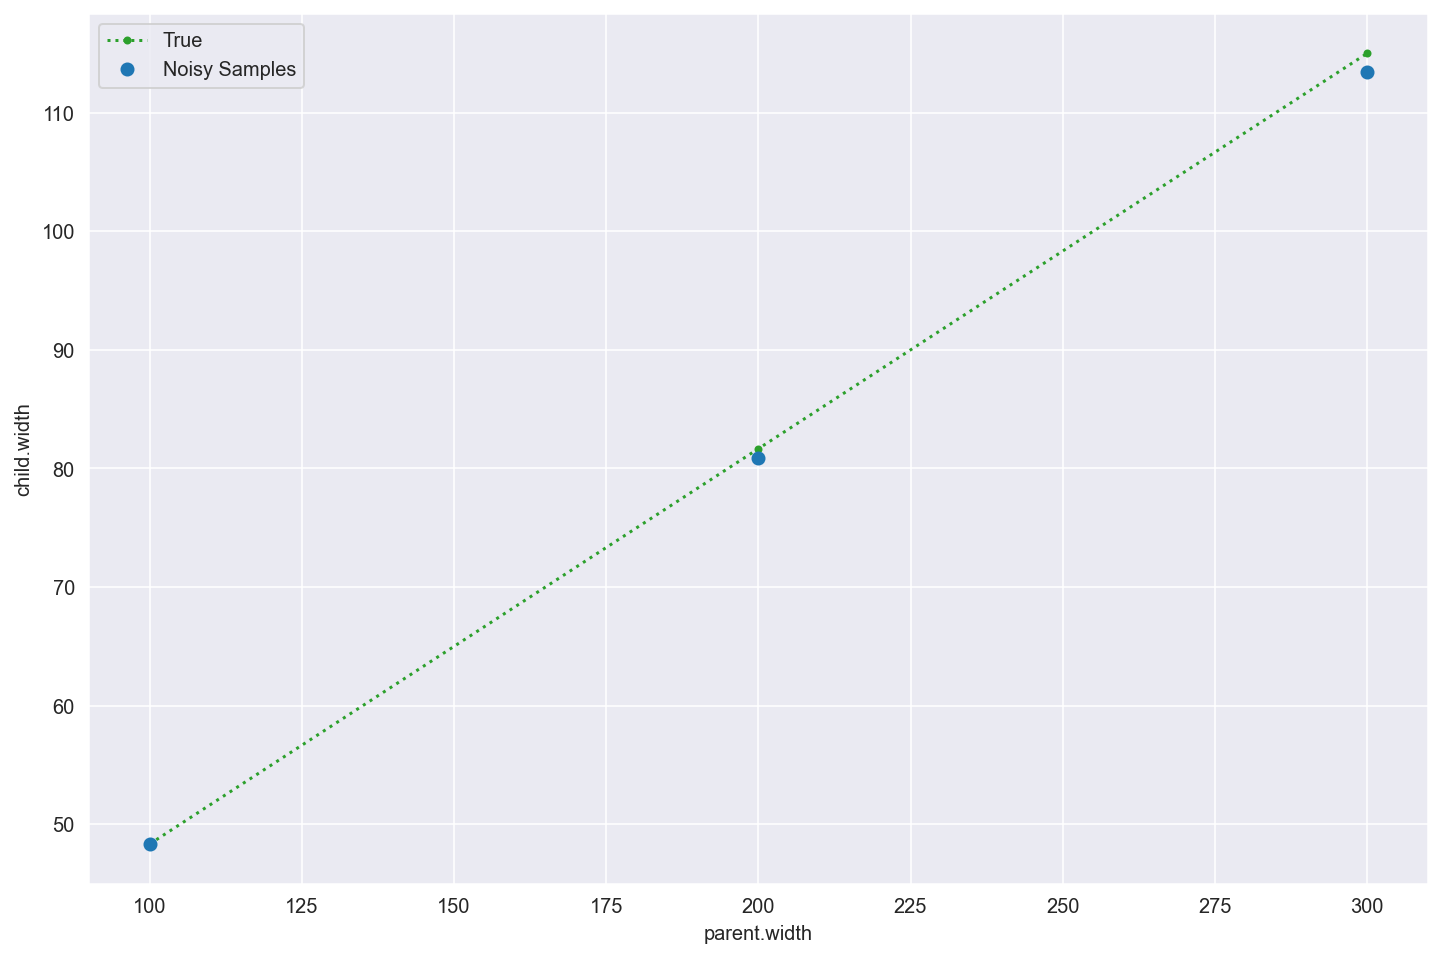

In [260]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y_true, ':.', color='tab:green', label="True");
ax.plot(x, y, 'o', data=df, label="Noisy Samples")

ax.set_xlabel('parent.width')
ax.set_ylabel('child.width')
ax.legend();

## Modeling

### Relaxed Model

The _relaxed_ model is more or less traditional Bayesian linear regression with continuous parameters and priors. The intent of this "preliminary phase" is to generate a good estimate as to the location of the best solution in the full model.

The full model is discrete, and it is therefore computationally expensive to find the maximum a posteriori estimate of (a, b). However, the relaxed model's MAP provides a very good estimate as to the location of the full model's MAP.

In [261]:
def mk_relaxed_model():
    relaxed_model = pm.Model()

    with relaxed_model:
        # y ~ N(⍺x + β, σ^2)
        data = pm.Data('data', x)
                
        σ = pm.HalfCauchy('σ', beta=(ε_px + TINY)/3)
        
        β = pm.Uniform('β', lower=B_MIN, upper=B_MAX)
        α = pm.Uniform('α', lower=A_MIN, upper=A_MAX)
        
        y_obs = pm.Normal('y_obs', mu=α*data + β, sigma=σ, observed=y)
        
    return relaxed_model
    
relaxed_model = mk_relaxed_model()
relaxed_model

In [262]:
relaxed_MAP = pm.find_MAP(model=relaxed_model)
a_MAP = relaxed_MAP['α']
b_MAP = relaxed_MAP['β']
sigma_MAP = relaxed_MAP['σ']
pprint(relaxed_MAP)


{'α': array(0.32552207),
 'α_interval__': array(-4.51261237),
 'β': array(15.79703141),
 'β_interval__': array(0.31860875),
 'σ': array(0.01140132),
 'σ_log__': array(-4.47402656)}


Text(0, 0.5, 'child.width')

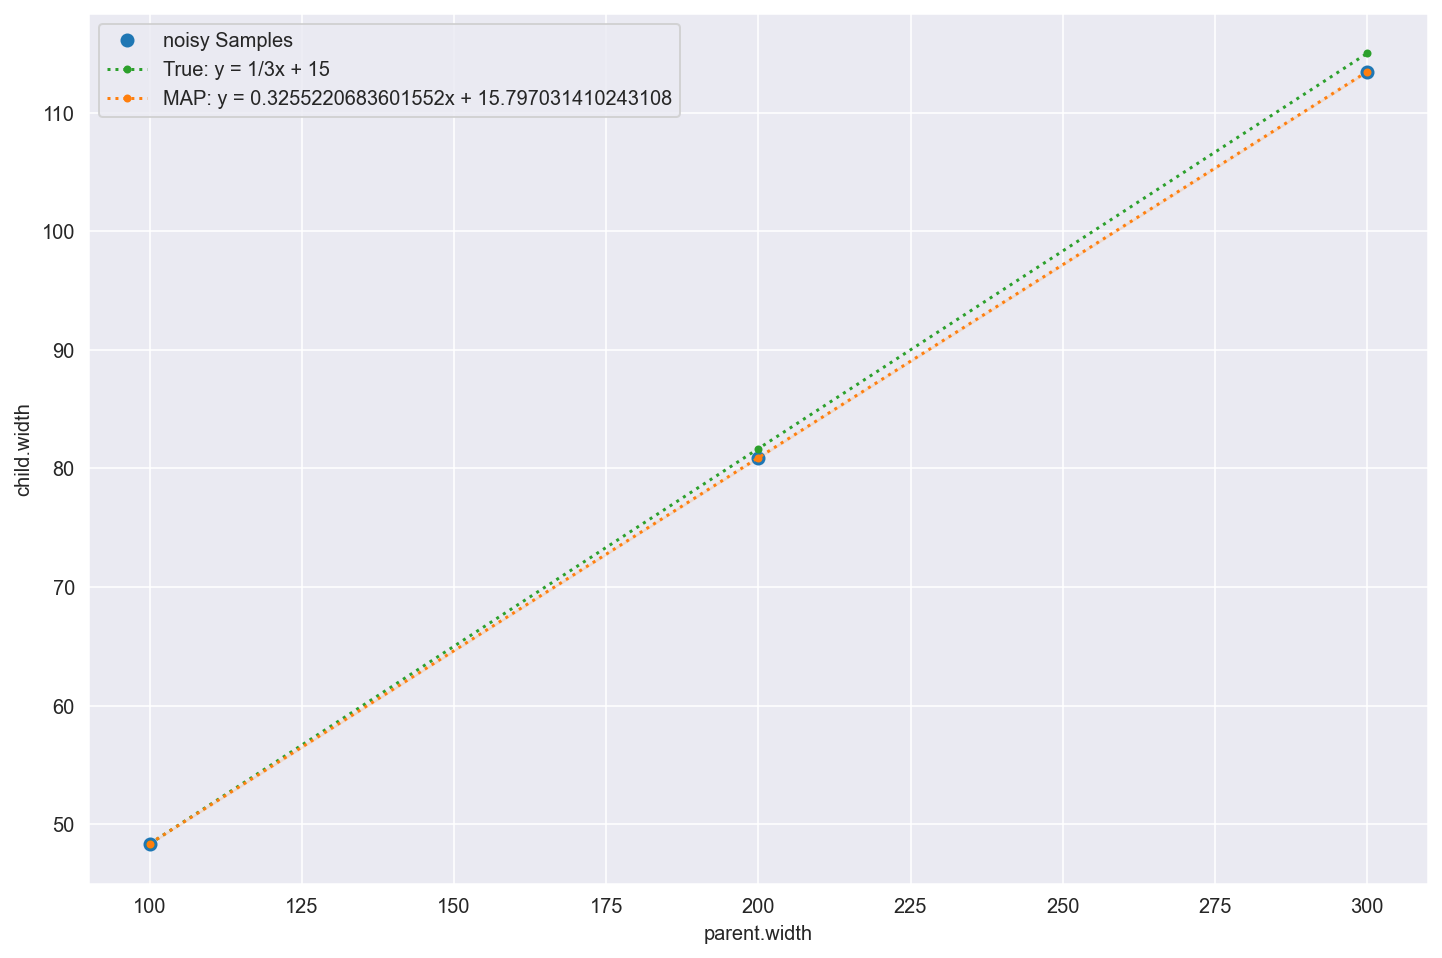

In [263]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y, 'o', label="noisy Samples")
ax.plot(x, y_true, ':.', color='tab:green', label=f"True: y = {a_true}x + {b_true}");
ax.plot(x, a_MAP*x+b_MAP, ':.', color='tab:orange', label=f"MAP: y = {a_MAP}x + {b_MAP}")
ax.fill_between(x, a_MAP*x+b_MAP + 3*sigma_MAP, a_MAP*x+b_MAP - 3*sigma_MAP, color='tab:orange', alpha=.1)
ax.legend()

ax.set_xlabel('parent.width')
ax.set_ylabel('child.width')

In [264]:
def candidate_bounds(x, y, relaxed_MAP):
    # Note: x and y should be in sorted order!
    
    sigma = np.exp(relaxed_MAP['σ'])
    
    x1, x2 = min(x), max(x)
    y1, y2 = min(y), max(y)
    
    # a = (y2 - y1) / (x2 - x1)
    a_lower = ((y2 + 3*sigma) - (y1 - 3*sigma)) / (x2 - x1)
    a_upper = ((y2 - 3*sigma) - (y1 + 3*sigma)) / (x2 - x1)
    
    # b = y - mx (where x,y = x1, y1 or x2, y2, equivalently)
    b_lower = y1 - a_lower*x1
    b_upper = y1 - a_upper*x1
    
    return a_lower, a_upper, b_lower, b_upper

def candidate_bounds_indices(a_space, b_space, a_lower, a_upper, b_lower, b_upper):
    a_i_lower = np.abs(a_space - a_lower).argmin()
    a_i_upper = np.abs(a_space - a_upper).argmin()
    b_i_lower = np.abs(b_space - b_lower).argmin()
    b_i_upper = np.abs(b_space - b_upper).argmin()
    return a_i_lower, a_i_upper, b_i_lower, b_i_upper

In [265]:
a_l, a_u, b_l, b_u = candidate_bounds(x, y, relaxed_MAP)
print(f"a: {a_l}...{a_u}, b: {b_l}...{b_u}")

a_i_l, a_i_u, b_i_l, b_i_u = candidate_bounds_indices(a_space_np, b_space_np, a_l, a_u, b_l, b_u)
print(a_i_l, a_i_u, b_i_l, b_i_u)

print(f"a: {a_space_np[a_i_l]}...{a_space_np[a_i_u]}, b: {b_space_np[b_i_l]}...{b_space_np[b_i_u]}")

a: 0.3558660650728569...0.2951780715938017, b: 12.770694038112183...18.839493386017697
98 81 113 119
a: 5/14...5/17, b: 13...19


## Full Model

In [266]:
with pm.Model() as model:    
    b_i = pm.DiscreteUniform('b_i', lower=0, upper=len(b_space_np))
    b = pm.Deterministic('b', b_space_th[b_i])
    
    
    
    a_i = pm.DiscreteUniform('a_i', lower=0, upper=len(a_space_np))
    a_p = pm.Deterministic('a_p', a_space_th[a_i][0])
    a_q = pm.Deterministic('a_q', a_space_th[a_i][1])

    y_observed = pm.Normal('y_observed', mu=(a_p / a_q) * x + b, sigma=(ε_px + TINY)/3, observed=y)

In [267]:
m_logp = model.logp

scores = sweep({
    'a_i': range(len(a_space_np)), 
    'b_i': range(len(b_space_np))
}, factor=model)

In [268]:
scale = scores['p'].sum()
scores['p'] = scores['p'] / scale
scores['p'].describe()

count    111200.000000
mean          0.000009
std           0.000868
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.144120
Name: p, dtype: float64

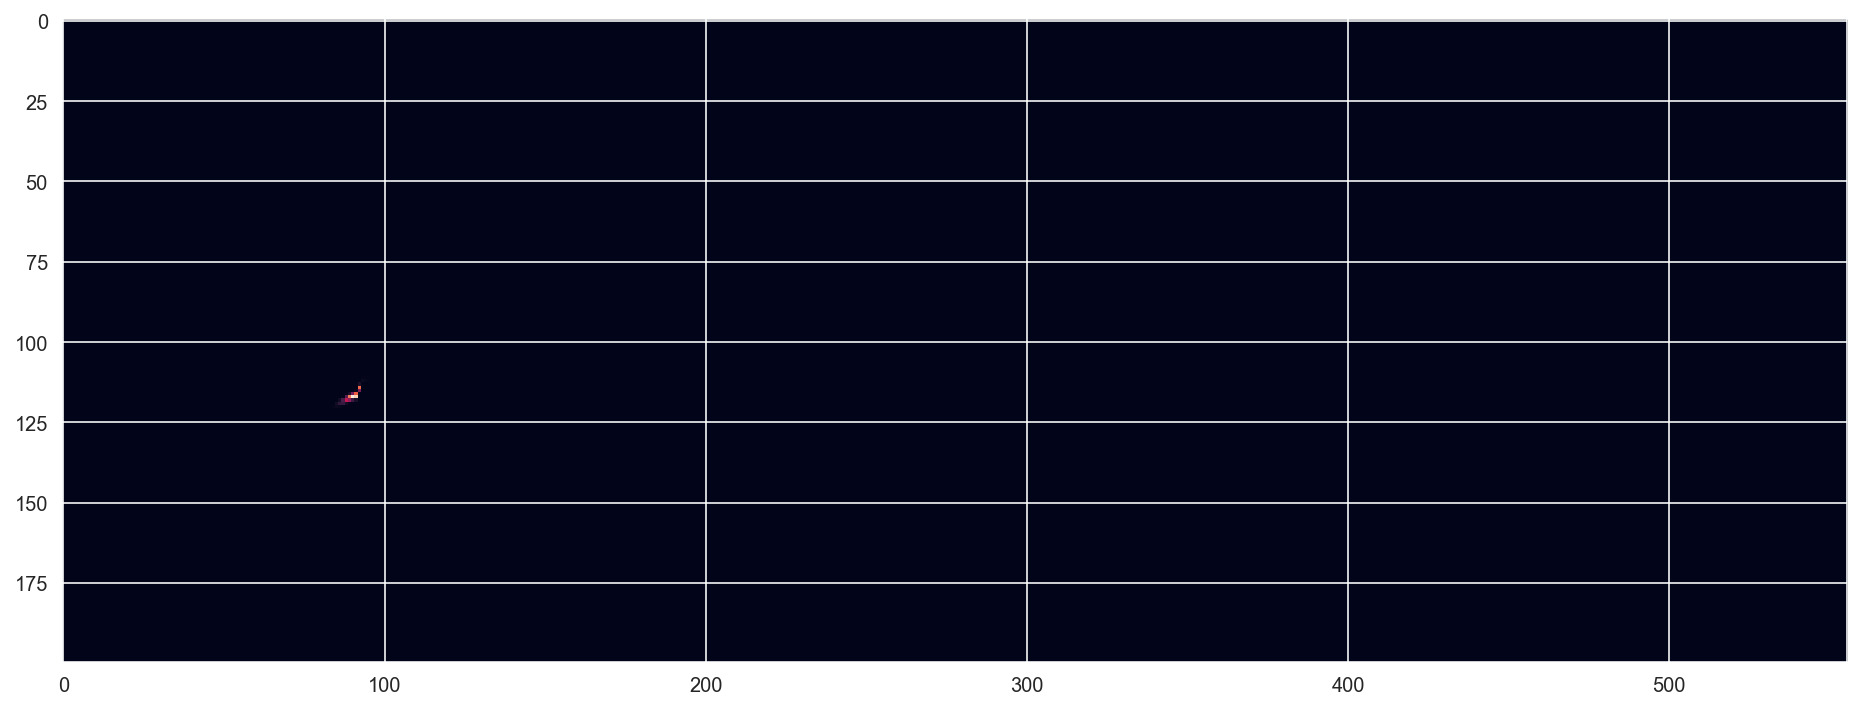

In [269]:
fig, ax = plt.subplots(figsize=(16, 16))
data = scores.pivot('b_i', 'a_i', 'p')
ax.imshow(data)

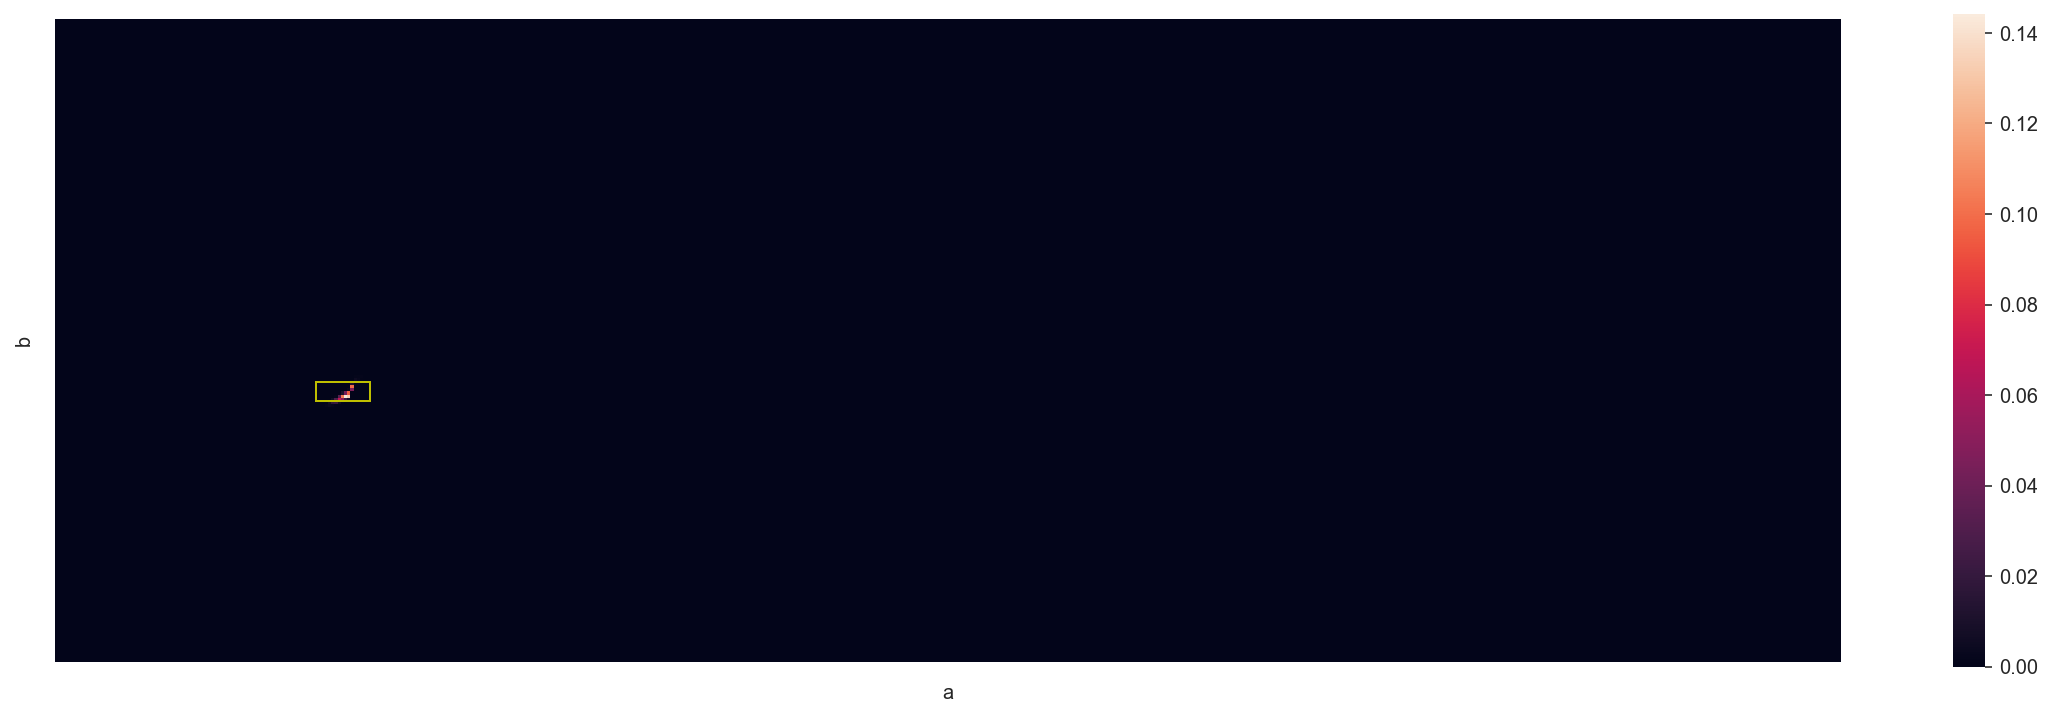

In [270]:
fig, ax = plt.subplots(figsize=(20, 6))
data = scores.pivot('b_i', 'a_i', 'p')
sns.heatmap(data, 
            ax=ax,
            xticklabels=a_space_np, 
            yticklabels=b_space_np,
            square=True);
plt.xlabel("a");
plt.ylabel("b");
# ax.hlines(list(range(len(b_choices))), *ax.get_xlim(), colors='darkslategray')
# ax.vlines(list(range(len(a_choices))), *ax.get_ylim(), colors='darkslategray')
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
ax.xaxis.set_major_locator(plt.MaxNLocator(100))
ax.add_artist(plt.Rectangle((a_i_l, b_i_l), (a_i_u - a_i_l), (b_i_u - b_i_l), color='y', fill=False, zorder=99));